In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
omegas = [100,400,625,900,1600]

Vs = []
I1s = []
I2s = []

for omega in omegas:
    data = pd.read_csv(f'17-03-25/{omega}.txt',sep = ';')
    V = data['Potential applied (V)'].values
    I1 = data['WE(1).Current (A)'].values
    I2 = data['WE(2).Current (A)'].values

    Vs.append(V)
    I1s.append(I1) # Corrente do Disco
    I2s.append(I2) # Corrente do Anel

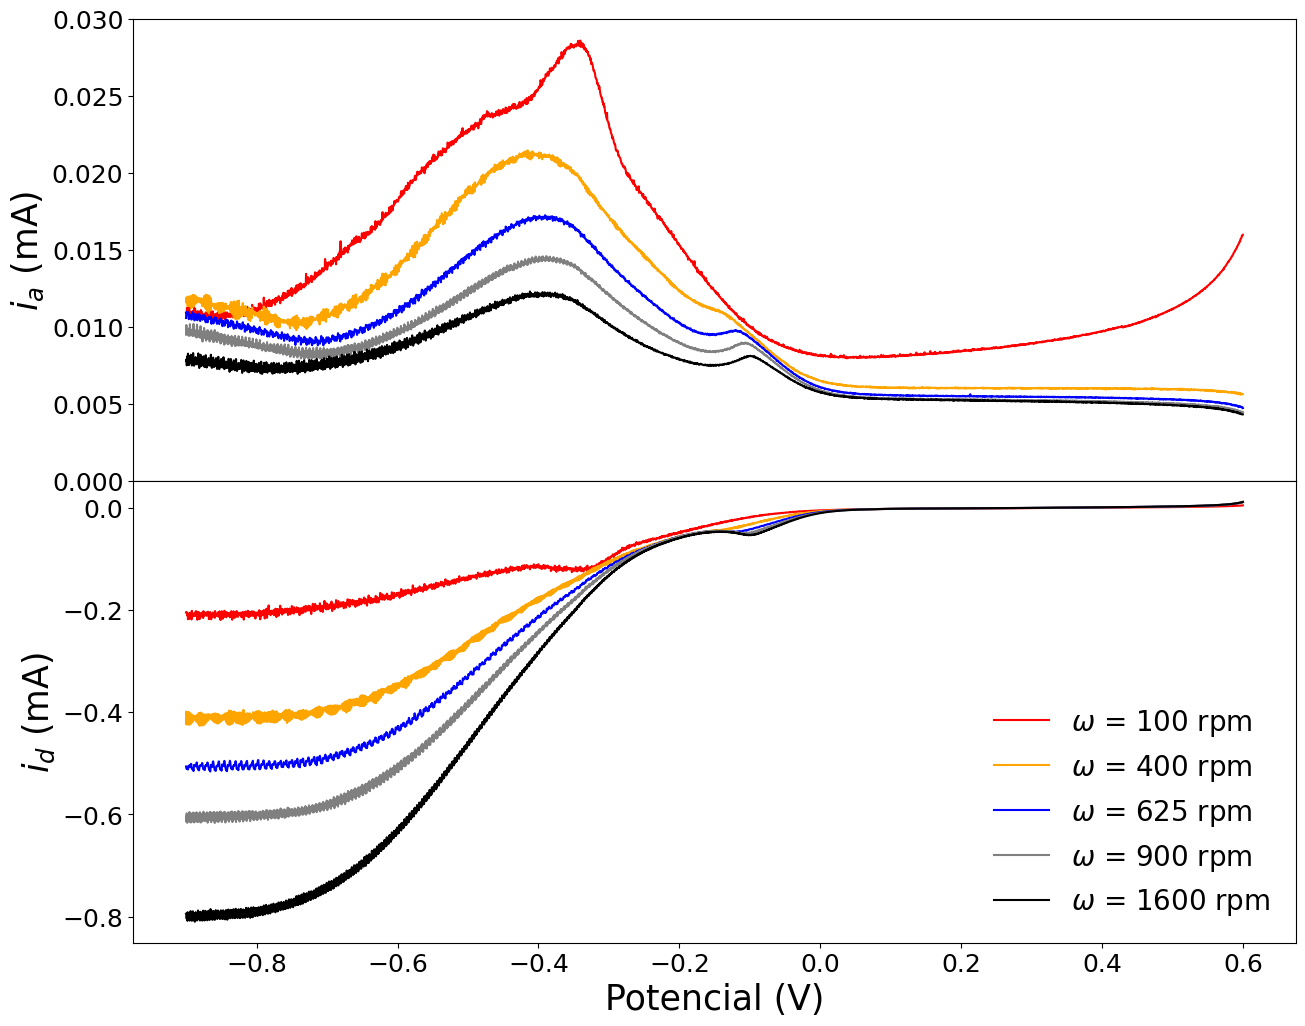

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
plt.subplots_adjust(hspace=0)

colors = ['red', 'orange', 'blue', 'gray', 'black']

for i, omega in enumerate(omegas):
    axs[1].plot(Vs[i], I1s[i] * 1000, color=colors[i], label=f'$\\omega$ = {omega} rpm')
    axs[0].plot(Vs[i], I2s[i] * 1000, color=colors[i])

axs[1].legend(frameon=False, fontsize = 20)
axs[1].set_ylabel('$i_d$ (mA)', fontsize=25)
axs[1].set_xlabel('Potencial (V)', fontsize=25)

axs[0].set_ylabel('$i_a$ (mA)', fontsize=25)
axs[0].set_ylim(0,0.030)

axs[0].tick_params(labelsize=18)
axs[1].tick_params(labelsize=18)

plt.savefig('Experimento.png', dpi=300)


**Usar fator de colea**

n = 3.58 ± 0.22


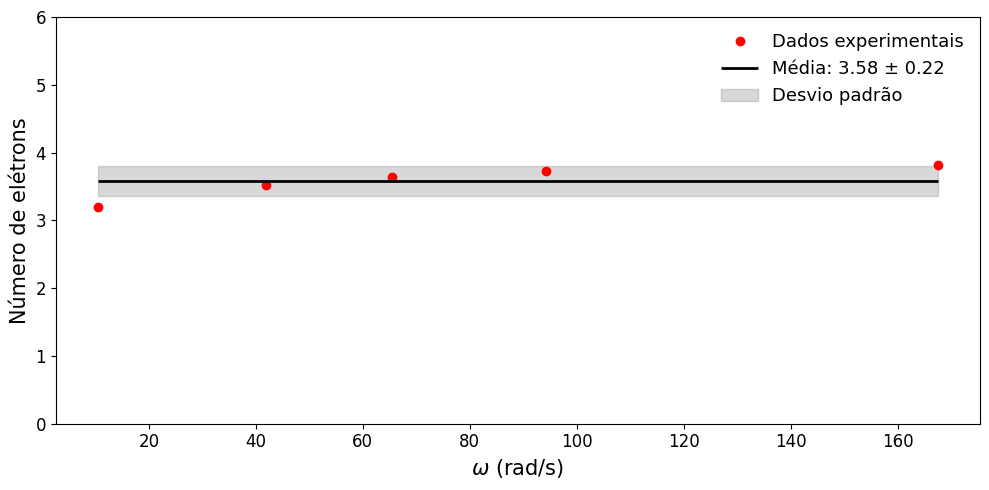

In [4]:
N = 0.21  # Coefficient of collection
ns = []

# Calcular o número de elétrons para cada omega
for i in range(len(Vs)):
    n_val = 4 * abs(I1s[i][-1]) / (abs(I1s[i][-1]) + abs(I2s[i][-1]) / N)
    ns.append(n_val)

# Cálculo da média e desvio padrão
ns = np.array(ns)
mean_n = np.mean(ns)
std_n = np.std(ns)

print('n =', np.round(mean_n, 2), '±', np.round(std_n, 2))

# Conversão de rpm para rad/s
omegas_rad = 2 * np.pi * np.array(omegas) / 60

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

# Pontos experimentais
ax.plot(omegas_rad, ns, 'o', color='red', label='Dados experimentais')

# Linha preta para a média
ax.hlines(mean_n, xmin=min(omegas_rad), xmax=max(omegas_rad), colors='black', linewidth=2, label=f'Média: {mean_n:.2f} ± {std_n:.2f}')

# Retângulo de incerteza ao redor da linha média
ax.fill_between(omegas_rad, mean_n - std_n, mean_n + std_n, color='gray', alpha=0.3, label='Desvio padrão')

# Estilo do gráfico
ax.set_ylabel('Número de elétrons', fontsize=15)
ax.set_xlabel(r'$\omega$ (rad/s)', fontsize=15)
ax.tick_params(labelsize=12)
ax.set_ylim(0, 6)
ax.legend(frameon=False, fontsize=13)

plt.tight_layout()
plt.savefig('n_vs_omega.png', dpi=300)
plt.show()


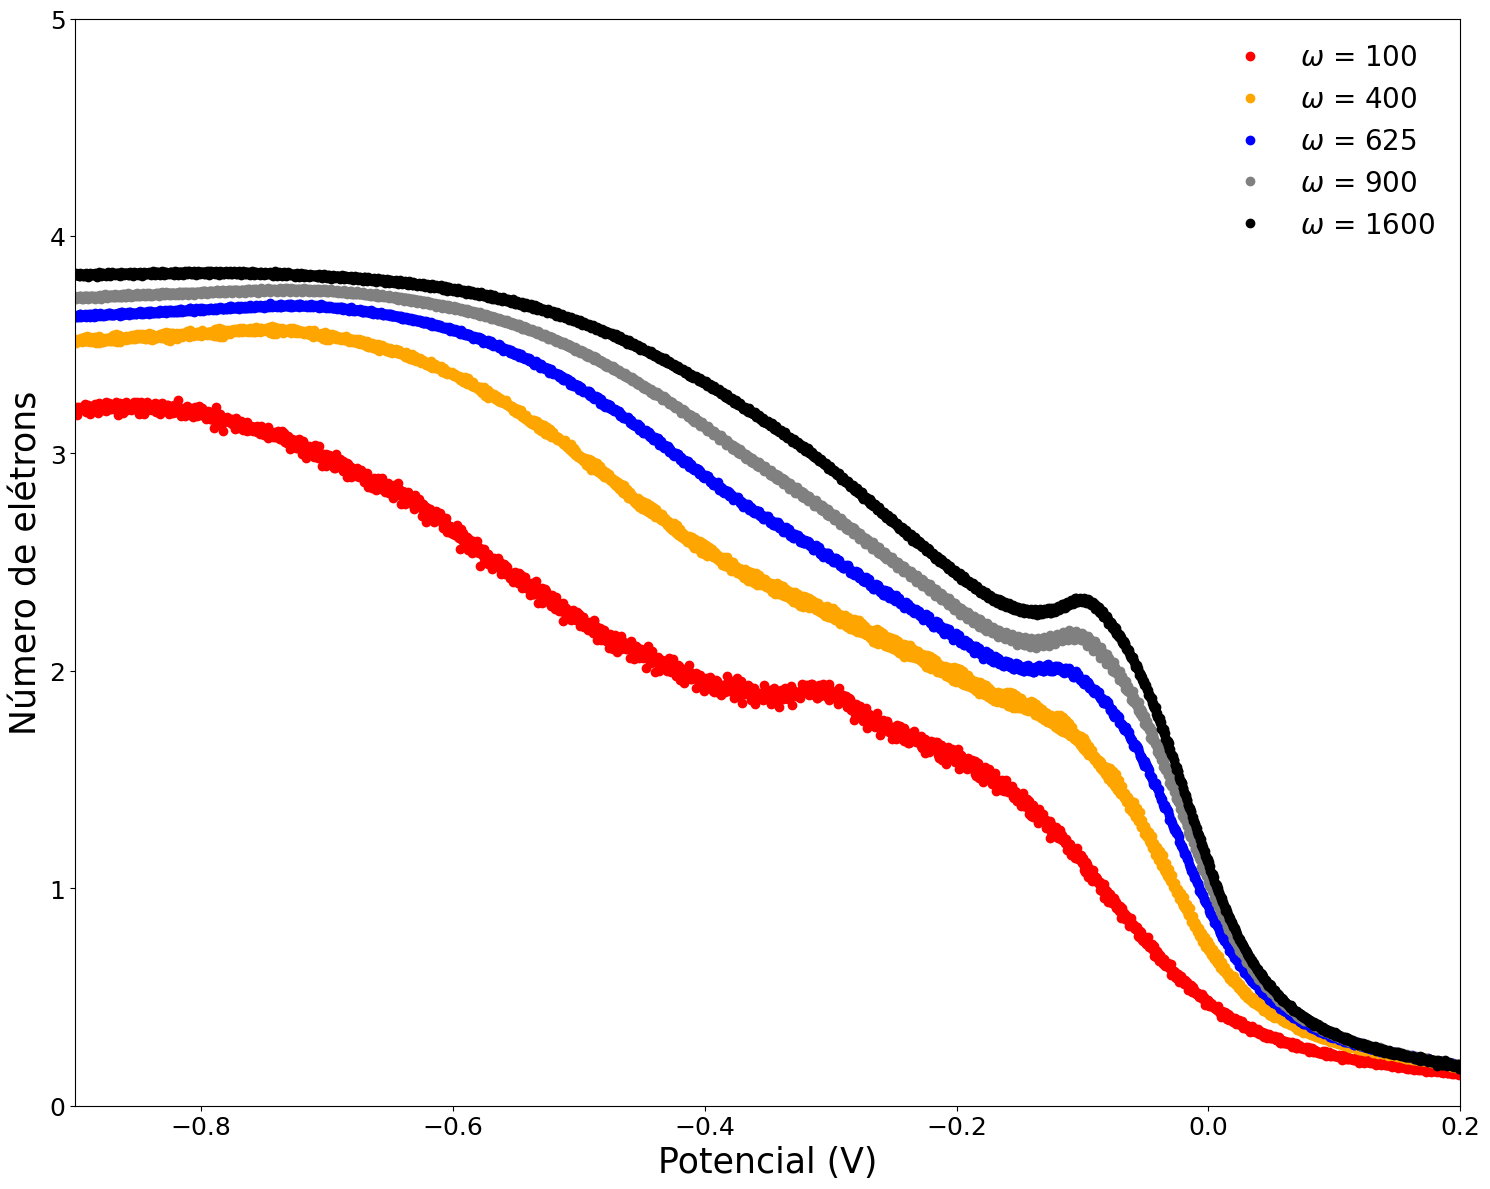

In [5]:
N = 0.21  # Coefficient of collection
ns = []

# Plot
fig, ax = plt.subplots(figsize=(15, 12))

# Calcular o número de elétrons para cada omega
for i in range(len(Vs)):
    n_val = 4 * np.array(I1s[i]) / ( abs(np.array(I1s[i])) + np.array(I2s[i]) / N)
    ns.append(n_val)

# Pontos experimentais
    ax.plot(Vs[i], abs(n_val), 'o', color = colors[i],label=f'$\omega$ = {omegas[i]}')

# Estilo do gráfico
ax.set_ylabel('Número de elétrons', fontsize=25)
ax.set_xlabel('Potencial (V)', fontsize=25)
ax.tick_params(labelsize=18)
ax.set_ylim(0,5)
ax.set_xlim(-0.9,0.2)
ax.legend(frameon=False, fontsize=20)

plt.tight_layout()
plt.savefig('Ns.png', dpi=300)
plt.show()


**Usar omegas**

n = 4.17 ± 0.03


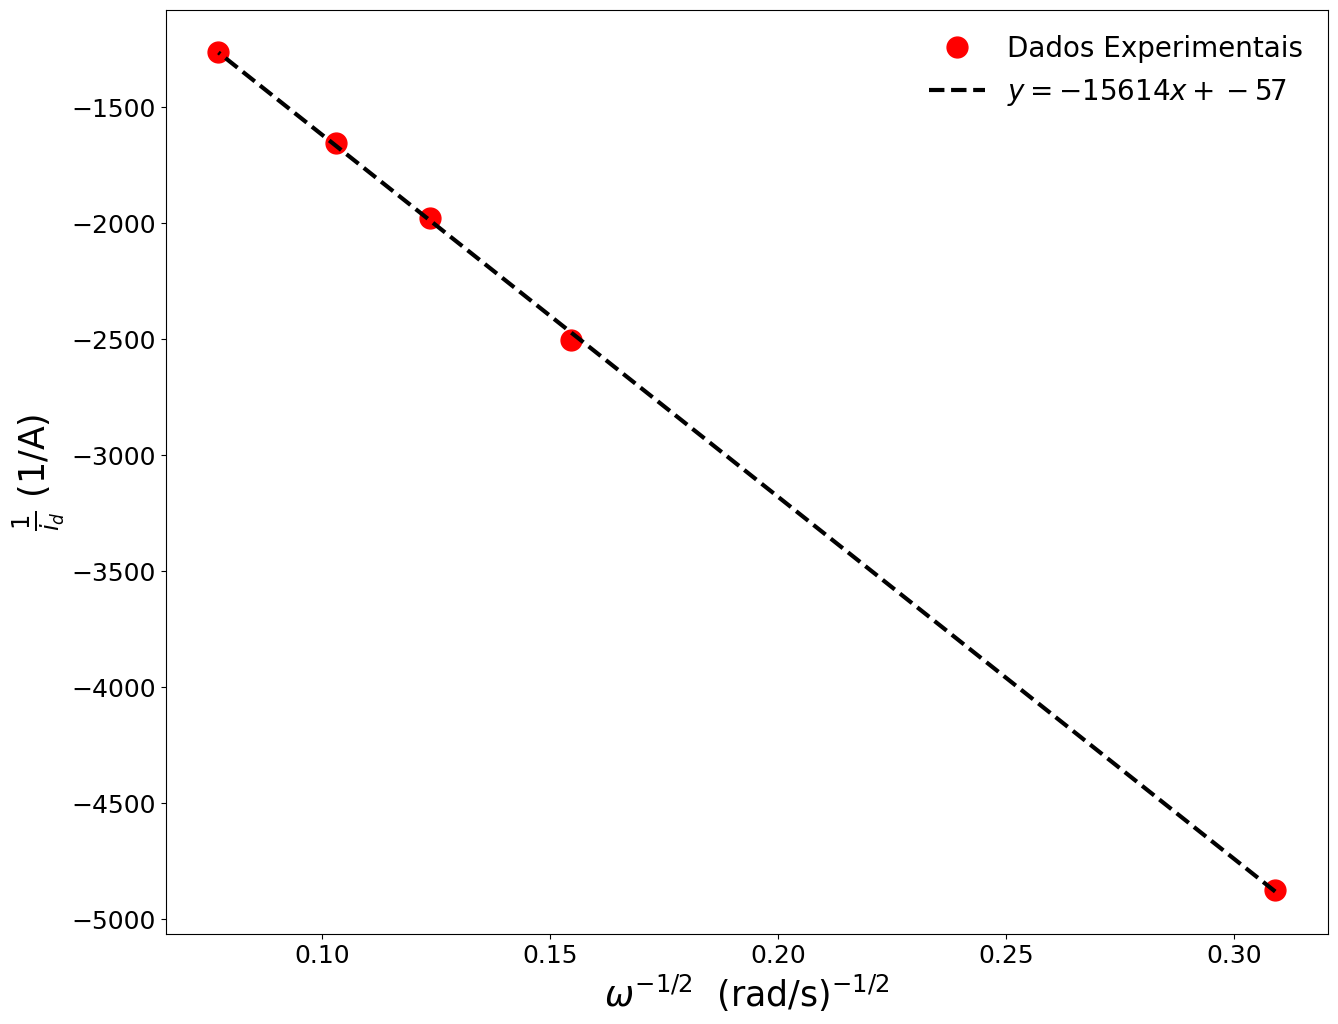

In [6]:
# Parâmetros experimentais e físicos
Adisco = 0.1866  # cm²
Aanel = 0.2475   # cm²
nu = 0.01        # cm²/s (viscosidade cinemática)
F = 96485        # C/mol (constante de Faraday)
D = 1.4e-5         # cm²/s (coef. de difusão de O2)
C = 1.1e-6       # mol/cm³ (concentração de O2)

# Ajuste da curva de Koutecký-Levich
def f(x, a, b):
    return a * x + b

omega_rad_s = 2 * np.pi * np.array(omegas) / 60
x_fit = omega_rad_s ** (-0.5)
y_fit = 1 / np.array(I1s)[:, -1]

params, std = curve_fit(f, x_fit, y_fit)
incl = params[0]

# Cálculo do número de elétrons
n = nu ** (1/6) / (0.62 * F * Adisco * D ** (2/3) * C * abs(incl))
erro_incl = np.sqrt(np.diag(std))[0]
erro_n = n * erro_incl / abs(incl)

# Gráfico
fig, axs = plt.subplots(figsize=(15, 12))
axs.plot(x_fit, y_fit, 'o', color='red',markersize=15, label='Dados Experimentais')
axs.plot(x_fit, f(x_fit, *params), '--', color='black',
         linewidth=3,label=fr'$y = {params[0]:.0f}x + {params[1]:.0f}$')

axs.legend(frameon=False, fontsize=20)
axs.set_ylabel(r'$\frac{1}{i_d}$ ($1/\mathrm{A}$)', fontsize=25)
axs.set_xlabel(r'$\omega^{-1/2}$  $(\mathrm{rad}/\mathrm{s})^{-1/2}$', fontsize=25)
axs.tick_params(labelsize=18)
# Exibe resultado
print(f'n = {n:.2f} ± {erro_n:.2f}')

plt.savefig('KL.png',dpi=300)